In [59]:
%run ../base_setup.ipynb

Foundation: 2.11.029
Transition: 3.02.016


-------------------------
## Synthetic Builder

In [60]:
builder = SyntheticBuilder.from_env('members')

In [61]:
tools = builder.intent_model

In [62]:
builder.pm.reset_intents()
builder.pm_persist()

In [63]:
sample_size = 1000
df = pd.DataFrame(index=range(sample_size))

-----------
### Distribution elements

In [64]:
# member_id
df['member_id'] = tools.get_number(from_value=100000000, to_value=999999789, at_most=1, size=sample_size, column_name='member_id')
builder.add_column_description(column_name='member_id', description="a unique id for the member")

In [65]:
df = tools.model_sample_map(canonical=df, sample_map='us_persona', female_bias=0.55, column_name='persona')
builder.add_column_description(column_name='persona', description="a base person template")

In [66]:
state_code = ['CA', 'NY', 'LA', 'NJ', 'VA', 'CO', 'NV', 'GA', 'IN', 'OH', 'KY', 'ME', 'MO', 'WI']
df = tools.model_sample_map(canonical=df, sample_map='us_zipcode', state_filter=state_code, column_name='zipcodes')
builder.add_column_description(column_name='zipcodes', description="Only covering 14 states woth a distribution based on population density")

In [67]:
# build up address starting with a number
df['address'] = tools.get_number(from_value=1, to_value=300000, precision=0, relative_freq=[50,10,5,3,2,1,1,1,1,], size=sample_size, column_name='address', intent_order=0)
builder.add_column_description(column_name='address', description="A realistc non-complex address")

In [68]:
# add in a name
df['address'] = tools.correlate_join(df, header='address', sep=' ', action=tools.action2dict(method='get_sample', sample_name='us_street_names', shuffle=True), column_name='address', intent_order=1)

In [69]:
# add road, sep=' ' types
df['address'] = tools.correlate_join(df, header='address', sep=' ', action=tools.action2dict(method='get_sample', sample_name='us_street_types', shuffle=True), column_name='address', intent_order=2)

In [70]:
# has phone number
df['prf_has_phone'] = tools.get_category(selection=[1, 0], relative_freq=[15,1], size=sample_size, column_name='prf_has_phone')
builder.add_column_description(column_name='prf_has_phone', description="If the person has a phone number on record.")

In [71]:
# ensure only thoise with Phone numbers elect to not be called
selection = [builder.tools.select2dict(column='prf_has_phone', condition='@==1')]

action = builder.tools.action2dict(method='get_category', selection=[1, 0], relative_freq=[1,20])
default = builder.tools.action2dict(method='@constant', value=0)

df['prf_not_call'] = builder.tools.correlate_selection(df, selection=selection, action=action, default_action=default, column_name='prf_not_call')
builder.add_column_description(column_name='prf_not_call', description="If the member has elected not to be called. Must have a phone number")

In [72]:
# communication channel preference
channels = ["SydneyCare", "RCP", "Phone", "Email", "SMS", "AgentAssist"]
df['prf_channel_pref'] = tools.get_category(selection=channels, relative_freq=[4,1,3,2,2, 0.1], size=sample_size, column_name='prf_channel_pref', intent_order=-1)
builder.add_column_description(column_name='prf_channel_pref', description="The channel through which the member can be contacted")

In [73]:
# ensure only thoise with sydneycare elkect to be notified
A = builder.tools.select2dict(column='prf_channel_pref', condition="@=='AgentAssist'")
B = builder.tools.select2dict(column='prf_channel_pref', condition="@=='RCP'", logic='AND')
selection = [[A, B], 'NOT']

action = builder.tools.action2dict(method='get_category', selection=[1, 0], relative_freq=[1,50])
default = builder.tools.action2dict(method='@constant', value=0)

df['prf_service_only'] = builder.tools.correlate_selection(df, selection=selection, action=action, default_action=default, column_name='prf_service_only')
builder.add_column_description(column_name='prf_service_only', description="If the member has elected to be contacted only for servicing purposes ")

In [74]:
# ensure if the member has no phone number the channel preference is not SMS or Phone
selection = [builder.tools.select2dict(column='prf_has_phone', condition='@==0')]

action = builder.tools.action2dict(method='get_category', selection=["SydneyCare", "RCP", "Email", "AgentAssist"], relative_freq=[2,1,2, 0.1])
default = builder.tools.action2dict(method='@header', header='prf_channel_pref')

df['prf_channel_pref'] = builder.tools.correlate_selection(df, selection=selection, action=action, default_action=default, column_name='prf_channel_pref', intent_order=-1)
builder.add_column_description(column_name='prf_channel_pref', description="ensure if the member has no phone number the channel preference is not SMS or Phone")

-----------
### Clinical Analytics

In [75]:
# load the sample dataset to analyse and rename columns
clinical_health = 'https://assets.datacamp.com/production/repositories/628/datasets/444cdbf175d5fbf564b564bd36ac21740627a834/diabetes.csv'
builder.add_connector_uri('clinical_health', uri=clinical_health)
df_clinical = builder.load_canonical('clinical_health')
col_names = [f"{'' if name == 'age' else 'cln_'}{name}" for name in df_clinical.columns]
df_clinical.columns = col_names

In [76]:
# create the analytics blob
columns_list=[{'age': {'dtype': 'int', 'precision': 0, 'granularity': 10.0, 'lower': 21, 'upper': 90, }}, 
              {'cln_diabetes': {'dtype': 'category'}},              
              {'cln_pregnancies': {'precision': 0, 'granularity': 2, }, 'cln_glucose': {'precision': 0, 'granularity': 2}, 
               'cln_diastolic': {'precision': 0, 'granularity': 2}, 'cln_triceps': {'precision': 0, 'granularity': 2, 'exclude_dominant': True}, 
               'cln_insulin': {'precision': 0, 'granularity': 2, 'exclude_dominant': True}, 'cln_bmi': {'precision': 1, 'granularity': 3}, 
               'cln_dpf': {'precision': 3, 'granularity': 2}}]
analysis_blob = Transition.from_memory().discover.analyse_association(df_clinical, columns_list=columns_list, detail_numeric=False)

In [77]:
# change the age distribution of the analysis blob
analysis_blob.get('age').get('insight').get('patterns').get('relative_freq')
analysis_blob.get('age').get('insight').get('patterns')['relative_freq'] = [23, 20, 14, 8, 4, 2, 0.4]
analysis_blob.get('age').get('insight').get('patterns').get('relative_freq')

[54.3, 20.44, 14.71, 7.03, 3.26, 0.13, 0.13]

[23, 20, 14, 8, 4, 2, 0.4]

In [78]:
# build the veracity model and create the synthetised results 
df = tools.model_analysis(df, analytics_model=analysis_blob, apply_bias=True, column_name='clinical')
builder.add_column_description(column_name='clinical', description="a section of clinical data taken from the sample reseach dataset on Diabetes")

In [79]:
df['cln_aptmt_dt'] = tools.get_datetime(start=-380, until=-15, relative_freq=[1,2,3,5,7,11], size=sample_size, date_format="%Y-%m-%d", column_name='cln_aptmt_dt')
builder.add_column_description(column_name='cln_aptmt_dt', description="The date of the appointment when the last clinical health data was taken")

In [80]:
# Adjust the pregnancies so there are no male
selection = [builder.tools.select2dict(column='gender', condition="@ =='M'")]

default = tools.action2dict(method='@header', header='cln_pregnancies')

df['cln_pregnancies'] = tools.correlate_selection(df, selection=selection, action=0, default_action=default, column_name='cln_pregnancies', intent_order=1)
builder.add_column_description(column_name='cln_pregnancies', description="Adjustment to ensure no males are have a value")

In [81]:
# check no males were pregnant
((df['cln_pregnancies'].values > 0) & (df['gender'] == 'M')).sum()

0

<AxesSubplot:xlabel='age', ylabel='Density'>

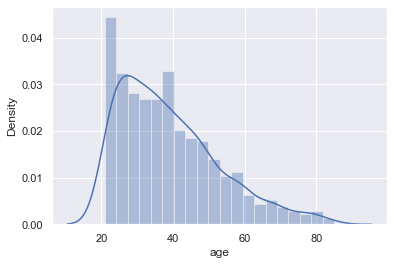

In [82]:
sns.set()
sns.distplot(df['age'], bins=20)

-------------------------
### Healthcare Segments

In [83]:
# member health plan
df['member_health_plan'] = tools.get_category(selection=['PPO', 'HMO'], relative_freq=[6, 4], size=sample_size, column_name='member_health_plan')
builder.add_column_description(column_name='member_health_plan', description="The member health plan")

In [84]:
# healthcare segment 
segment = ["Local Group", "National Accounts", "Medicaid", "BlueCard", "FEP", "Individual"]
df['segment'] = tools.get_category(selection=segment, relative_freq=[38, 19, 18, 15, 4, 2], size=sample_size, column_name='segment', intent_order=0)
builder.add_column_description(column_name='segment', description="The heathcare segment of the member with bias weighting")

In [85]:
# Adjust age for medicare being over 65
selection = [builder.tools.select2dict(column='age', condition='@ >= 65')]

action = tools.action2dict(method='get_category', selection=['Medicare', "Local Group", "National Accounts", "Medicaid"], relative_freq=[99, 0.8, 0.1, 0.1])
default = tools.action2dict(method='@header', header='segment')

df['segment'] = tools.correlate_selection(df, selection=selection, action=action, default_action=default, column_name='segment', intent_order=1)

In [86]:
# # line of buisness
correlations = [["Medicaid", "Medicare"]]
actions = {0: tools.action2dict(method='@constant', value='Business')}

df['line_of_business'] = tools.correlate_categories(df, header='segment', correlations=correlations, actions=actions, default_action='Commercial', column_name='line_of_business')
builder.add_column_description(column_name='line_of_business', description="The line of business this segment is in")

In [87]:
# remove some emails addresses for over 60's
selection = [builder.tools.select2dict(column='age', condition='@ >= 60')]

action = builder.tools.action2dict(method='get_category', selection=[1, 0], relative_freq=[50, 1])

df['prf_has_email'] = builder.tools.correlate_selection(df, selection=selection, action=action, default_action=1, column_name='prf_has_email')
builder.add_column_description(column_name='prf_has_email', description="If the member has an email address on record")

In [88]:
# match the email to the prf_has_email
selection = [builder.tools.select2dict(column='prf_has_email', condition='@ == 0')]

action = tools.action2dict(method='@constant', value="")
default = tools.action2dict(method='@header', header='email')

df['email'] = builder.tools.correlate_selection(df, selection=selection, action=action, default_action=default, column_name='email')
builder.add_column_description(column_name='email', description="trimming those with email address for over 60s from the persona emails")

-------------------------
### Flu Vaccine

In [89]:
# Flu vaccine ICD
df['ins_icd_10_code'] = tools.get_category(selection=['Z23', 'Z28', '0'], relative_freq=[4.5, 1.5, 4], size=sample_size, column_name='ins_icd_10_code', intent_order=0)
builder.add_column_description(column_name='ins_icd_10_code', description="The ICD codes for flu vaccination, Z23 - charable vaccine, Z28 - refused vaccine")

In [90]:
# adjust flu shot for over 65
selection = [builder.tools.select2dict(column='age', condition='@>=65')]

action = builder.tools.action2dict(method='get_category', selection=['Z23', 'Z28', '0'], relative_freq=[6.5, 1, 2.5])
default = builder.tools.action2dict(method='@header', header='ins_icd_10_code')

df['ins_icd_10_code'] = builder.tools.correlate_selection(df, selection=selection, action=action, default_action=default, column_name='ins_icd_10_code', intent_order=1)

In [91]:
# adjust flu shot for under 49
selection = [builder.tools.select2dict(column='age', condition='@<=49')]

action = builder.tools.action2dict(method='get_category', selection=['Z23', 'Z28', '0'], relative_freq=[3, 1, 6])
default = builder.tools.action2dict(method='@header', header='ins_icd_10_code')

df['ins_icd_10_code'] = builder.tools.correlate_selection(df, selection=selection, action=action, default_action=default, column_name='ins_icd_10_code', intent_order=2)

In [92]:
# Flu vaccine CPT
df['ins_cpt_code'] = tools.get_category(selection=['90674', '90682', '90686', '90688', '90694', '90756'], relative_freq=[13, 7, 1, 0.5, 0.1, 0.01], size=sample_size, column_name='ins_cpt_code', intent_order=0)
builder.add_column_description(column_name='ins_cpt_code', description="The CPT codes for flu vaccination, Z23 - charable vaccine, Z28 - refused vaccine")

In [93]:
# adjust flu shot for over 75
selection = [builder.tools.select2dict(column='age', condition='@>=65')]

action = builder.tools.action2dict(method='get_category', selection=['90653', '90662'], relative_freq=[13, 7])
default = builder.tools.action2dict(method='@header', header='ins_cpt_code')

df['ins_cpt_code'] = builder.tools.correlate_selection(df, selection=selection, action=action, default_action=default, column_name='ins_cpt_code', intent_order=1)

In [94]:
# adjust previous flu shot for under 49
selection = [builder.tools.select2dict(column='age', condition='@<=49')]

action = builder.tools.action2dict(method='get_category', selection=['90672', '90674', '90682', '90686'], relative_freq=[13, 7, 3, 1])
default = builder.tools.action2dict(method='@header', header='ins_cpt_code')

df['ins_cpt_code'] = builder.tools.correlate_selection(df, selection=selection, action=action, default_action=default, column_name='ins_cpt_code', intent_order=2)

In [95]:
# Those on Medicare should have a specific code
selection = [builder.tools.select2dict(column='segment', condition="@=='Medicare'"),
            builder.tools.select2dict(column='ins_icd_10_code', condition="@=='Z23'", logic='AND')]

action = builder.tools.action2dict(method='@constant', value='G0008')
default = builder.tools.action2dict(method='@header', header='ins_cpt_code')

df['ins_cpt_code'] = builder.tools.correlate_selection(df, selection=selection, action=action, default_action=default, column_name='ins_cpt_code', intent_order=3)

In [96]:
# those with no ICD code should have no CPT
selection = [builder.tools.select2dict(column='ins_icd_10_code', condition="@!='Z23'")]

action = builder.tools.action2dict(method='@constant', value='0')
default = builder.tools.action2dict(method='@header', header='ins_cpt_code')

df['ins_cpt_code'] = builder.tools.correlate_selection(df, selection=selection, action=action, default_action=default, column_name='ins_cpt_code', intent_order=4)

In [97]:
# add a date in if ICD is Z23
selection = [builder.tools.select2dict(column='ins_icd_10_code', condition="@=='Z23'")]

action = builder.tools.action2dict(method='get_datetime', start=-380, until=-180, relative_freq=[20, 10, 5, 1], ignore_time=True, date_format='%Y-%m-%d')
default = builder.tools.action2dict(method='@constant', value='')

df['ins_cpt_dt'] = builder.tools.correlate_selection(df, selection=selection, action=action, default_action=default, column_name='ins_cpt_dt')
builder.add_column_description(column_name='ins_cpt_dt', description="if had a previous flu shot, a date between 300 and 600 days previous to today")


### Asign a PCP to each member

In [98]:
# assign PCP tax_id
sample_data = tools.action2dict(method='model_sample_map', canonical=tools.action2dict(method='@empty'), sample_map='us_healthcare_practitioner', headers=['city', 'pcp_tax_id'], shuffle=False)
merge_data = tools.action2dict(method='model_group', canonical=sample_data, headers='pcp_tax_id', group_by='city', aggregator='list')
df = tools.model_merge(df, merge_data, how='left', left_on='city', right_on='city', column_name='pcp_tax_id')
builder.add_column_description(column_name='pcp_tax_id', description="Taken from the sample healthcare practitioners, matches a city to a practitioner list")

In [99]:
# select one of the options from the pcp_tax_id list
df['pcp_tax_id'] = tools.correlate_choice(df, header='pcp_tax_id', list_size=1, random_choice=True, shuffle=False, column_name='pcp_tax_id')

In [100]:
# is PCP auto assigned where there is a pc_tax_id
selection = [builder.tools.select2dict(column='pcp_tax_id', condition='@.isna()')]

df['is_PCP_auto_assigned'] = tools.correlate_selection(df, selection=selection, action=0, default_action=1, column_name='is_PCP_auto_assigned')
builder.add_column_description(column_name='is_PCP_auto_assigned', description="if the PCP has been auto assigned with a 7/3 positive distribution")

### Run Reports

In [101]:
builder.canonical_report(df)

,Attributes (36),dType,%_Null,%_Dom,Count,Unique,Observations
0,address,object,0.0%,0.1%,1000,1000,Sample: 5255 Chaldon Ferry | 8393 Llanengan Spur | 11091 Castle Arch Valley | 32012 Swiss Boulevard ...
1,age,int64,0.0%,4.2%,1000,63,max=85 | min=21 | mean=38.9 | dominant=27
2,city,object,0.0%,2.0%,1000,828,Sample: New York | Los Angeles | Fresno | Manhattan | Columbus
3,cln_aptmt_dt,object,0.0%,1.0%,1000,301,Sample: 2021-02-02 | 2021-01-09 | 2021-02-10 | 2021-02-09 | 2021-01-18
4,cln_bmi,float64,0.0%,2.1%,1000,317,max=65.6 | min=0.6 | mean=31.94 | dominant=19.6
5,cln_diabetes,int64,0.0%,61.1%,1000,2,max=1 | min=0 | mean=0.39 | dominant=0
6,cln_diastolic,int64,0.0%,2.8%,1000,112,max=121 | min=0 | mean=74.11 | dominant=75
7,cln_dpf,float64,0.0%,2.0%,1000,650,max=2.341 | min=0.078 | mean=0.61 | dominant=0.832
8,cln_glucose,int64,0.0%,2.5%,1000,176,max=196 | min=0 | mean=122.94 | dominant=119
9,cln_insulin,float64,0.0%,53.5%,1000,278,max=817.0 | min=0.0 | mean=86.01 | dominant=0.0


In [102]:
builder.report_column_catalog()

,column_name,description
0,address,A realistc non-complex address
1,clinical,a section of clinical data taken from the sample reseach dataset on Diabetes
2,cln_aptmt_dt,The date of the appointment when the last clinical health data was taken
3,cln_pregnancies,Adjustment to ensure no males are have a value
4,email,trimming those with email address for over 60s from the persona emails
5,ins_cpt_code,"The CPT codes for flu vaccination, Z23 - charable vaccine, Z28 - refused vaccine"
6,ins_cpt_dt,"if had a previous flu shot, a date between 300 and 600 days previous to today"
7,ins_icd_10_code,"The ICD codes for flu vaccination, Z23 - charable vaccine, Z28 - refused vaccine"
8,is_PCP_auto_assigned,if the PCP has been auto assigned with a 7/3 positive distribution
9,line_of_business,The line of business this segment is in


## Run the Pipeline  save the Schema and show the Canonical Report

In [103]:
# run the pipeline
builder.run_component_pipeline(size=sample_size)

# report the stored schema
builder.canonical_report(builder.load_persist_canonical(), stylise=True)

,Attributes (36),dType,%_Null,%_Dom,Count,Unique,Observations
0,address,object,0.0%,0.1%,1000,1000,Sample: 39606 Flying Jib Mill | 168870 Roblar Drives | 4669 Oldstead Creek | 32451 Pointe View Well ...
1,age,int64,0.0%,4.0%,1000,64,max=90 | min=21 | mean=39.18 | dominant=29
2,city,object,0.0%,1.9%,1000,845,Sample: New York | Los Angeles | Kansas City | Sacramento | Denver
3,cln_aptmt_dt,object,0.0%,1.3%,1000,304,Sample: 2021-02-03 | 2021-01-25 | 2021-02-09 | 2021-02-08 | 2021-01-15
4,cln_bmi,float64,0.0%,2.0%,1000,306,max=64.6 | min=4.3 | mean=32.1 | dominant=19.6
5,cln_diabetes,int64,0.0%,58.8%,1000,2,max=1 | min=0 | mean=0.41 | dominant=0
6,cln_diastolic,int64,0.0%,2.5%,1000,110,"max=121 | min=0 | mean=75.97 | dominant=[69, 70]"
7,cln_dpf,float64,0.0%,2.0%,1000,668,max=2.29 | min=0.082 | mean=0.62 | dominant=0.832
8,cln_glucose,int64,0.0%,3.0%,1000,178,max=198 | min=0 | mean=127.64 | dominant=119
9,cln_insulin,float64,0.0%,53.5%,1000,303,max=816.0 | min=0.0 | mean=95.84 | dominant=0.0


In [104]:
builder.load_persist_canonical().head(5)

,member_id,prf_has_phone,cln_aptmt_dt,member_health_plan,first_name,middle_name,gender,family_name,email,city,state_abbr,state,county_fips,county,zipcode,age,cln_diabetes,cln_pregnancies,cln_glucose,cln_diastolic,cln_triceps,cln_insulin,cln_bmi,cln_dpf,pcp_tax_id,address,prf_not_call,prf_channel_pref,prf_service_only,segment,line_of_business,prf_has_email,ins_icd_10_code,ins_cpt_code,ins_cpt_dt,is_PCP_auto_assigned
0,899199812,1,2021-01-04,HMO,Shaye,Maison,M,Mitchko,shaye.mitchko@games.com,Whitehall,OH,Ohio,39049,Franklin,43213,54,1,0,134,105,0.000,0.000,32.900,0.590,278973722.000,11520 Pinyon Extension,0,SydneyCare,0,Local Group,Commercial,1,Z23,90674,2020-04-02,1
1,393399931,1,2021-01-13,PPO,Mesai,Dervin,M,Dugie,mesai.dugie@aol.com,Barlow,KY,Kentucky,21007,Ballard,42024,49,0,0,13,19,48.000,0.000,53.000,0.219,NaN,19086 Linnie Groves,0,SydneyCare,0,Local Group,Commercial,1,Z23,90672,2020-04-16,0
2,801549835,1,2020-09-25,PPO,Esau,Gearard,M,Ugartechea,esau.ugartechea@juno.com,Endicott,NY,New York,36007,Broome,13737,27,0,0,114,77,0.000,0.000,29.600,0.790,774366475.000,21565 Stacey Court,0,SMS,0,Medicaid,Business,1,0,0,,1
3,103149999,1,2021-02-08,PPO,Tiye,Princecharles,F,Rollan,tiye.rollan@mail.com,Jeffersontown,KY,Kentucky,21111,Jefferson,40220,25,0,4,174,90,15.000,164.000,27.500,0.757,715386382.000,145477 Amberwood Plaza,0,SydneyCare,0,Medicaid,Business,1,Z23,90682,2020-04-17,1
4,239049967,1,2020-08-25,HMO,Mukund,Rainbow,M,Lautermilch,mukund.lautermilch@aol.com,Silver Lake,OH,Ohio,39153,Summit,44224,45,0,0,96,60,48.000,307.000,56.900,0.890,NaN,30801 Hot As Texas Row,0,SydneyCare,0,Medicaid,Business,1,0,0,,0


-------------------------
-------------------------
## Members Transition

In [105]:
tr = Transition.from_env('members')

In [106]:
tr.pm.reset_intents()
tr.pm_persist()

In [107]:
df = tr.load_source_canonical()

In [108]:
# clean the data
tr.cleaners.auto_clean_header(df, inplace=True)
tr.cleaners.auto_transition(df, inplace=True)
tr.cleaners.to_str_type(df, dtype='object', inplace=True)
tr.cleaners.to_str_type(df, headers=['address', 'city', 'county', 'state', 'first_name', 'family_name', 'middle_name', 'email'], use_string_type=True, inplace=True)
tr.cleaners.to_remove(df, headers=['county_fips'], inplace=True)
tr.cleaners.to_remove(df, regex=['cln_', 'prf_', 'ins_'], inplace=True)

In [109]:
tr.upload_attributes(builder.report_column_catalog(stylise=False), label_key='column_name', text_key='description', constraints=list(df.columns))

## Run the Pipeline  save the Schema and show the Schema Report

In [110]:
# run the pipeline
tr.run_component_pipeline()

# report the stored schema
tr.canonical_report(tr.load_persist_canonical(), stylise=True)

,Attributes (19),dType,%_Null,%_Dom,Count,Unique,Observations
0,address,string,0.0%,0.1%,1000,1000,Sample: 39606 Flying Jib Mill | 168870 Roblar Drives | 4669 Oldstead Creek | 32451 Pointe View Well ...
1,age,int64,0.0%,4.0%,1000,64,max=90 | min=21 | mean=39.18 | dominant=29
2,city,string,0.0%,1.9%,1000,845,Sample: New York | Los Angeles | Kansas City | Sacramento | Denver
3,county,string,0.0%,4.6%,1000,399,Sample: Los Angeles | Nassau | New York | Jefferson | Jackson
4,county_fips,int64,0.0%,4.6%,1000,477,max=55141 | min=6001 | mean=26368.55 | dominant=6037
5,email,string,0.1%,0.1%,1000,1000,Sample: theo.limage@googlemail.com | raeleigh.faires@me.com | anikka.katzmarek@lavabit.com | aman.da...
6,family_name,string,0.0%,0.2%,1000,998,Sample: Khademi | Miyasato | Ohlen | Boren | Turiello
7,first_name,string,0.0%,0.2%,1000,998,Sample: Paige | Bobby | Rayder | Rondell | Kerby
8,gender,category,0.0%,55.0%,1000,2,Sample: F | M
9,is_PCP_auto_assigned,bool,0.0%,68.1%,1000,2,True | False


-------------------------
-------------------------
## Clinical Members Transition

In [111]:
tr = Transition.from_env('cln_members')

In [112]:
tr.pm.reset_intents()
tr.pm_persist()

In [113]:
df = tr.load_source_canonical()

In [114]:
# clean the data
tr.cleaners.auto_clean_header(df, inplace=True)
tr.cleaners.auto_transition(df, inplace=True)
tr.cleaners.to_str_type(df, dtype='object', inplace=True)
tr.cleaners.to_date_type(df, headers='ins_cpt_dt', inplace=True)
tr.cleaners.to_select(df, regex=['cln_', 'member_id'], inplace=True)

In [115]:
tr.upload_attributes(builder.report_column_catalog(stylise=False), label_key='column_name', text_key='description', constraints=list(df.columns))

## Run the Pipeline  save the Schema and show the Schema Report

In [116]:
# run the pipeline
tr.run_component_pipeline()

# report the stored schema
tr.canonical_report(tr.load_persist_canonical(), stylise=True)

,Attributes (10),dType,%_Null,%_Dom,Count,Unique,Observations
0,cln_aptmt_dt,datetime64[ns],0.0%,1.3%,1000,304,max=2021-02-14 00:00:00 | min=2020-02-16 00:00:00 | yr mean= 2020
1,cln_bmi,float64,0.0%,2.0%,1000,306,max=64.6 | min=4.3 | mean=32.1 | dominant=19.6
2,cln_diabetes,bool,0.0%,58.8%,1000,2,True | False
3,cln_diastolic,int64,0.0%,2.5%,1000,110,"max=121 | min=0 | mean=75.97 | dominant=[69, 70]"
4,cln_dpf,float64,0.0%,2.0%,1000,668,max=2.29 | min=0.082 | mean=0.62 | dominant=0.832
5,cln_glucose,int64,0.0%,3.0%,1000,178,max=198 | min=0 | mean=127.64 | dominant=119
6,cln_insulin,float64,0.0%,53.5%,1000,303,max=816.0 | min=0.0 | mean=95.84 | dominant=0.0
7,cln_pregnancies,int64,0.0%,49.6%,1000,17,max=16 | min=0 | mean=2.72 | dominant=0
8,cln_triceps,float64,0.0%,34.5%,1000,66,max=93.0 | min=0.0 | mean=19.69 | dominant=0.0
9,member_id,int64,0.0%,0.1%,1000,1000,"max=999549789 | min=100000000 | mean=542319295.81 | dominant=[100000000, 100449999]"


-------------------------
-------------------------
## Preference Members Transition

In [117]:
tr = Transition.from_env('prf_members')

In [118]:
tr.pm.reset_intents()
tr.pm_persist()

In [119]:
df = tr.load_source_canonical()

In [120]:
# clean the data
tr.cleaners.auto_clean_header(df, inplace=True)
tr.cleaners.auto_transition(df, inplace=True)
tr.cleaners.to_str_type(df, dtype='object', inplace=True)
tr.cleaners.to_select(df, regex=['prf_', 'member_id'], inplace=True)

In [121]:
tr.upload_attributes(builder.report_column_catalog(stylise=False), label_key='column_name', text_key='description', constraints=list(df.columns))

## Run the Pipeline  save the Schema and show the Schema Report

In [122]:
# run the pipeline
tr.run_component_pipeline()

# report the stored schema
tr.canonical_report(tr.load_persist_canonical(), stylise=True)

,Attributes (6),dType,%_Null,%_Dom,Count,Unique,Observations
0,member_id,int64,0.0%,0.1%,1000,1000,"max=999549789 | min=100000000 | mean=542319295.81 | dominant=[100000000, 100449999]"
1,prf_channel_pref,category,0.0%,35.0%,1000,6,Sample: SydneyCare | Phone | Email | SMS | RCP
2,prf_has_email,bool,0.0%,99.9%,1000,2,True | False
3,prf_has_phone,bool,0.0%,94.6%,1000,2,True | False
4,prf_not_call,bool,0.0%,95.2%,1000,2,False | True
5,prf_service_only,bool,0.0%,97.7%,1000,2,False | True


-------------------------
-------------------------
## Insurance Claims Members Transition

In [123]:
tr = Transition.from_env('ins_members')

In [124]:
tr.pm.reset_intents()
tr.pm_persist()

In [125]:
df = tr.load_source_canonical()

In [126]:
# clean the data
tr.cleaners.auto_clean_header(df, inplace=True)
tr.cleaners.auto_transition(df, inplace=True)
tr.cleaners.to_str_type(df, dtype='object', inplace=True)
tr.cleaners.to_select(df, regex=['ins_', 'member_id'], inplace=True)

In [127]:
tr.upload_attributes(builder.report_column_catalog(stylise=False), label_key='column_name', text_key='description', constraints=list(df.columns))

## Run the Pipeline  save the Schema and show the Schema Report

In [128]:
# run the pipeline
tr.run_component_pipeline()

# report the stored schema
tr.canonical_report(tr.load_persist_canonical(), stylise=True)

,Attributes (4),dType,%_Null,%_Dom,Count,Unique,Observations
0,ins_cpt_code,category,0.0%,68.7%,1000,7,Sample: 0 | 90672 | 90674 | 90682 | G0008
1,ins_cpt_dt,object,68.7%,68.7%,1000,125,Sample: 2020-03-14 | 2020-02-21 | 2020-03-11 | 2020-02-26 | 2020-02-24
2,ins_icd_10_code,category,0.0%,56.6%,1000,3,Sample: 0 | Z23 | Z28
3,member_id,int64,0.0%,0.1%,1000,1000,"max=999549789 | min=100000000 | mean=542319295.81 | dominant=[100000000, 100449999]"
